# 0. 다양한 OCR모델 비교하기

영수증을 OCR하는 모델을 만들어보자.  
Google OCR API, keras-ocr, Tesseract 세 가지 모델을 만들어보고 어떤 모델이 가장 완성도가 높은지 비교해보자.

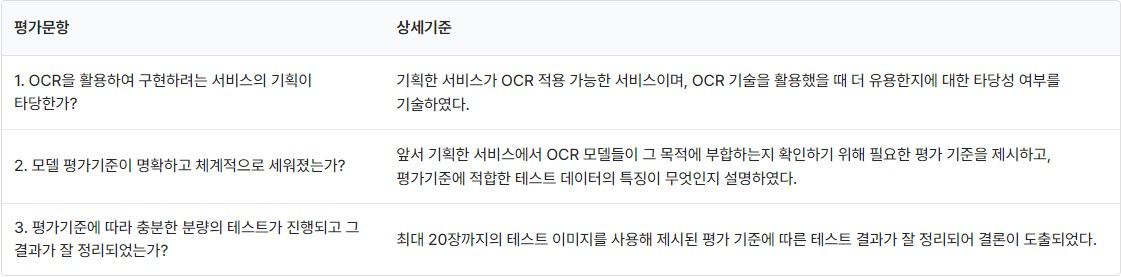

영수증의 글자들을 추출하는 방법으로는 OCR밖에 떠오르지 않는다.  
고로 OCR을 활용하는 것은 타당하다.

OCR은 Optical Character Recognition(광학 문자 인식)의 줄임말이다.

OCR은 크게 두 가지 과정이 있다.  
먼저 입력받은 사진 속에서 문자의 위치를 찾아내는 문자 검출(Text Detection),  
찾은 문자 영역으로부터 문자를 읽어내는 문자 인식(Text Recognition).

In [1]:
# !pip install --upgrade google-api-python-client
# !pip install google-cloud-vision
# !pip install keras-ocr
# !pip install pytesseract

In [2]:
import os, io

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img

from google.cloud import vision
import cv2
from PIL import ImageFont, ImageDraw, Image
import platform

import keras_ocr

import pytesseract
from PIL import Image
from pytesseract import Output

# !sudo apt install tesseract-ocr

/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(


# 1. 검증용 데이터셋 준비하기

In [4]:
work_dir = os.getenv('HOME') + '/aiffel/ocr_python'

In [5]:
# 테스트에 사용할 이미지 url을 모아 봅니다. 추가로 더 모아볼 수도 있습니다. 
image_list = [
    '/colab_receipt.jpg',
    '/drive_receipt.jpg'
]

image_paths = [work_dir + image_path for image_path in image_list]

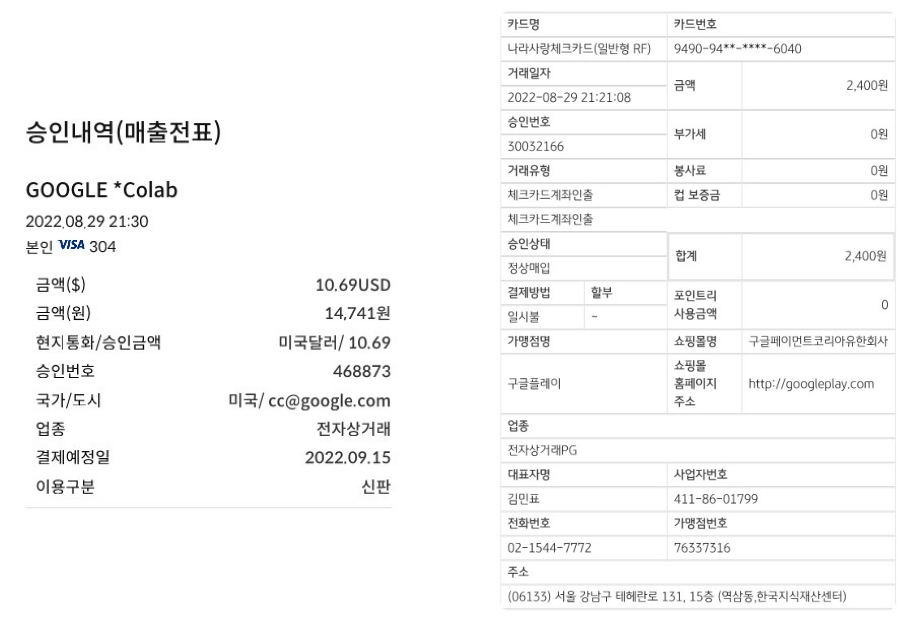

In [6]:
plt.figure(figsize=(16, 16))

for idx, image_path in enumerate(image_paths):
    plt.subplot(1, 2, idx + 1)
    image_path = img.imread(image_path)
    plt.imshow(image_path)
    plt.axis('off')

plt.show()

실제 나의 영수증을 가져와봤다.

# 2. Google OCR API, keras-ocr, Tesseract로 테스트하기

## 2.1. Google OCR API

In [7]:
def plt_imshow(title='image', img=None, figsize=(8 ,5)):
    plt.figure(figsize=figsize)
 
    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []
 
            for i in range(len(img)):
                titles.append(title)
 
        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
 
            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])
 
        plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
 
        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()

In [8]:
def putText(image, text, x, y, color=(0, 255, 0), font_size=22):
    if type(image) == np.ndarray:
        color_coverted = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(color_coverted)
 
    if platform.system() == 'Darwin':
        font = 'AppleGothic.ttf'
    elif platform.system() == 'Windows':
        font = 'malgun.ttf'
    elif platform.system() == 'Linux':
        font = 'NanumGothic.ttf'
        
    image_font = ImageFont.truetype(font, font_size)
    font = ImageFont.load_default()
    draw = ImageDraw.Draw(image)
 
    draw.text((x, y), text, font=image_font, fill=color)
    
    numpy_image = np.array(image)
    opencv_image = cv2.cvtColor(numpy_image, cv2.COLOR_RGB2BGR)
 
    return opencv_image

In [9]:
def detect_text(path):
    """Detects text in the file."""
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    
    img = cv2.imread(path)
    roi_img = img.copy()
    
#     print('Texts:')

    for idx, text in enumerate(texts):
        if idx == 0:
            ocr_text_full = text.description
        
#         print('\n"{}"'.format(text.description))
        vertices = (['({},{})'.format(vertex.x, vertex.y)
            for vertex in text.bounding_poly.vertices])
#         print('bounds: {}'.format(','.join(vertices)))
        ocr_text = text.description
        x1 = text.bounding_poly.vertices[0].x
        y1 = text.bounding_poly.vertices[0].y
        x2 = text.bounding_poly.vertices[1].x
        y2 = text.bounding_poly.vertices[2].y
        
        cv2.rectangle(roi_img, (int(x1), int(y1)), (int(x2), int(y2)), (0,255,0), 2)
        roi_img = putText(roi_img, ocr_text, x1, y1 - 30, font_size=30)        
    
    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

    plt_imshow(["Original", "ROI"], [img, roi_img], figsize=(16, 10))
    
    return ocr_text_full

In [10]:
# 로컬 환경에서는 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# 클라우드 환경에서는 무시해도 좋습니다
# !ls -l $GOOGLE_APPLICATION_CREDENTIALS 
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  work_dir + '/my_google_api_key.json'
print(os.environ["GOOGLE_APPLICATION_CREDENTIALS"])

/aiffel/aiffel/ocr_python/my_google_api_key.json


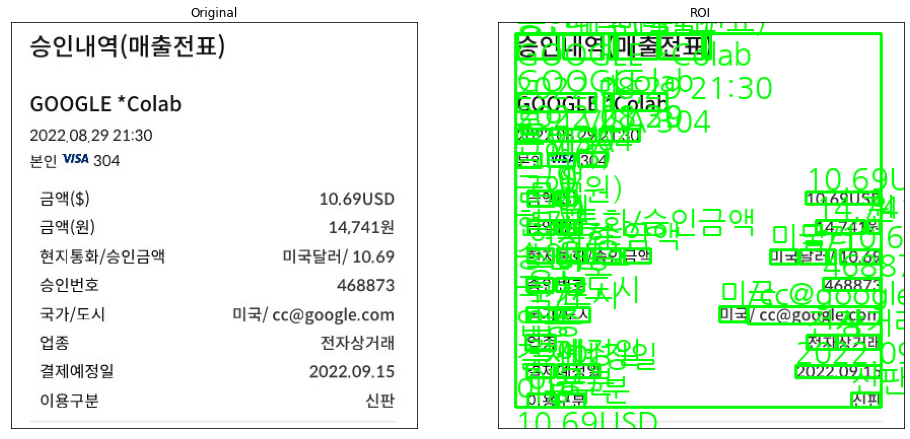

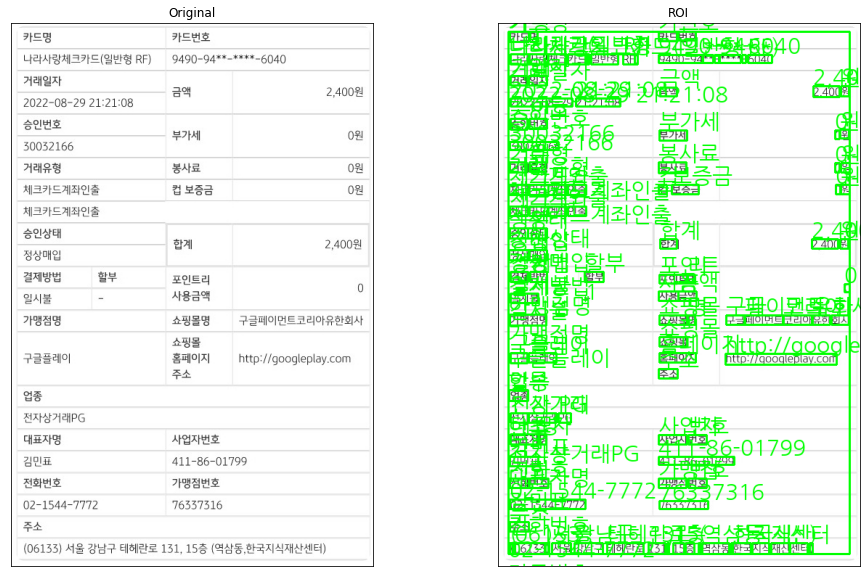

In [11]:
# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
colab_text = detect_text(image_paths[0])
drive_text = detect_text(image_paths[1])

In [12]:
print(colab_text)

승인내역(매출전표)
GOOGLE *Colab
2022,08,29 21:30
본인 VISA 304
금액($)
금액(원)
현지통화/승인금액
승인번호
국가/도시
업종
결제예정일
이용구분
10.69USD
14,741원
미국달러 / 10.69
468873
미국/cc@google.com
전자상거래
2022.09.15
신판


In [13]:
print(drive_text)

카드명
나라사랑체크카드(일반형 RF)
거래일자
2022-08-29 21:21:08
승인번호
30032166
거래유형
체크카드계좌인출
체크카드계좌인출
승인상태
정상매입
결제방법
일시불
가맹점명
구글플레이
할부
1
업종
전자상거래PG
대표자명
김민표
전화번호
02-1544-7772
카드번호
9490-94**-****-6040
금액
부가세
봉사료
컵 보증금
합계
포인트리
사용금액
쇼핑몰명
쇼핑몰
홈페이지
주소
2,400원
사업자번호
411-86-01799
가맹점번호
76337316
0원
0원
0원
2,400원
구글페이먼트코리아유한회사
http://googleplay.com
주소
(06133) 서울 강남구 테헤란로 131, 15층 (역삼동,한국지식재산센터)
0


역시 구글이다. 거의 뭐 완벽하다고 볼 수 있다.

## 2.2. keras-ocr

In [14]:
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


이미지 리스트를 정리한 후 반복문을 실행하며 모듈이 출력한 결과를 모아 봅시다.

In [15]:
images = [keras_ocr.tools.read(image_path) for image_path in image_paths]
prediction_groups = [pipeline.recognize([image_path]) for image_path in image_paths]

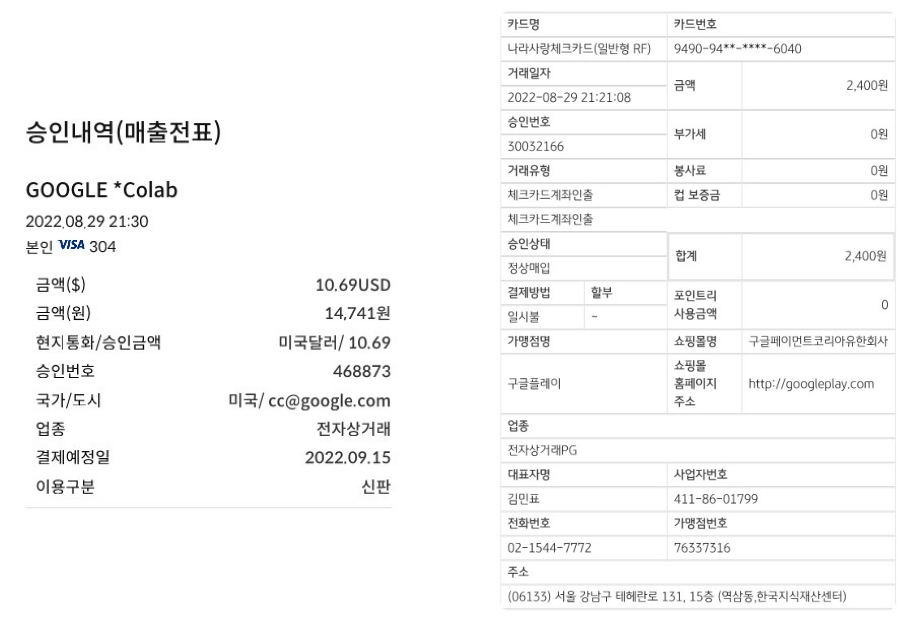

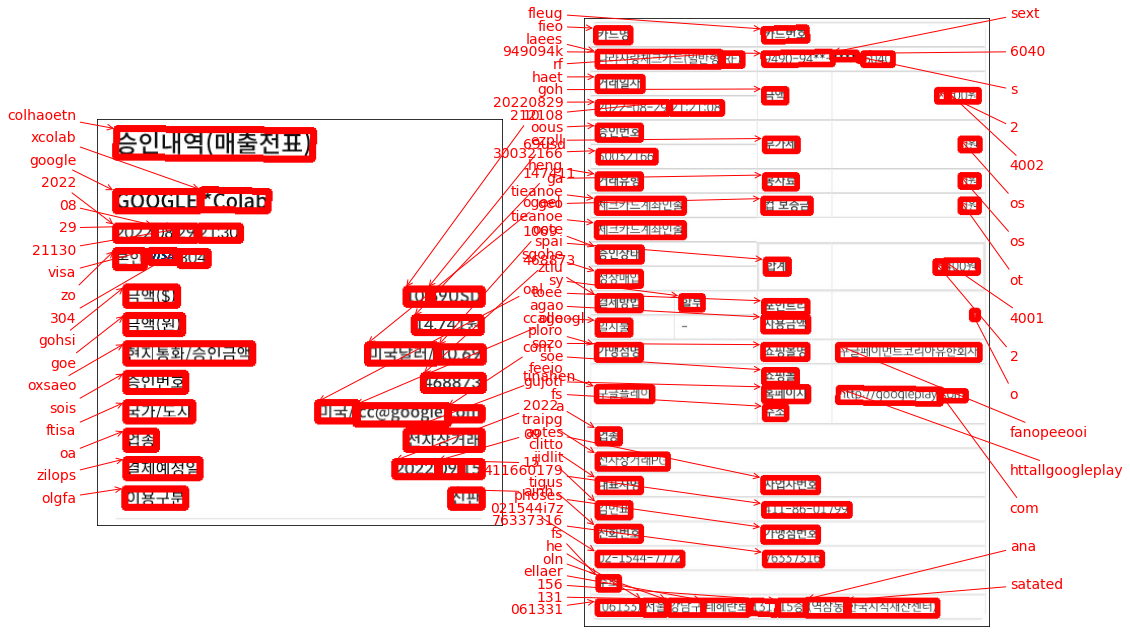

In [16]:
plt.figure(figsize=(16, 16))

for idx, image_path in enumerate(image_paths):
    plt.subplot(1, 2, idx + 1)
    image_path = img.imread(image_path)
    plt.imshow(image_path)
    plt.axis('off')

plt.show()

# Plot the predictions
fig, axs = plt.subplots(ncols=len(images), figsize=(16, 16))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

keras-ocr은 안타깝게도 한글은 지원하지 않는다. 사용해보는 것에 중점을 뒀다.

## 2.3. Tesseract

OCR Engine modes(–oem):  
0 - Legacy engine only.  
1 - Neural nets LSTM engine only.  
2 - Legacy + LSTM engines.  
3 - Default, based on what is available.  

Page segmentation modes(–psm):  
0 - Orientation and script detection (OSD) only.  
1 - Automatic page segmentation with OSD.  
2 - Automatic page segmentation, but no OSD, or OCR.  
3 - Fully automatic page segmentation, but no OSD. (Default)  
4 - Assume a single column of text of variable sizes.  
5 - Assume a single uniform block of vertically aligned text.  
6 - Assume a single uniform block of text.  
7 - Treat the image as a single text line.  
8 - Treat the image as a single word.  
9 - Treat the image as a single word in a circle.  
10 - Treat the image as a single character.  
11 - Sparse text. Find as much text as possible in no particular order.  
12 - Sparse text with OSD.  
13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

oem_psm_config를 변경하며 모델을 만들어보자.  
결과가 매우 달라지는 것을 볼 수 있다.

In [35]:
def crop_word_regions(image_path='./images/sample.png', output_path='./output', fname=None):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)
    img = cv2.imread(image_path)
    roi_img = img.copy()

    recognized_data = pytesseract.image_to_data(
        image, lang='kor+eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            cv2.rectangle(roi_img, (int(left), int(top)), (int(left) + int(width), int(top) + int(height)), (0,255,0), 2)
            roi_img = putText(roi_img, recognized_data['text'][i], left, top - 15, font_size=15)       
            output_img_path = os.path.join(output_path + f"/images/{fname}_{str(index).zfill(2)}.png")
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
#             cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
            
    plt_imshow(["Original", "ROI"], [img, roi_img], figsize=(16, 10))

    return recognized_data['text']


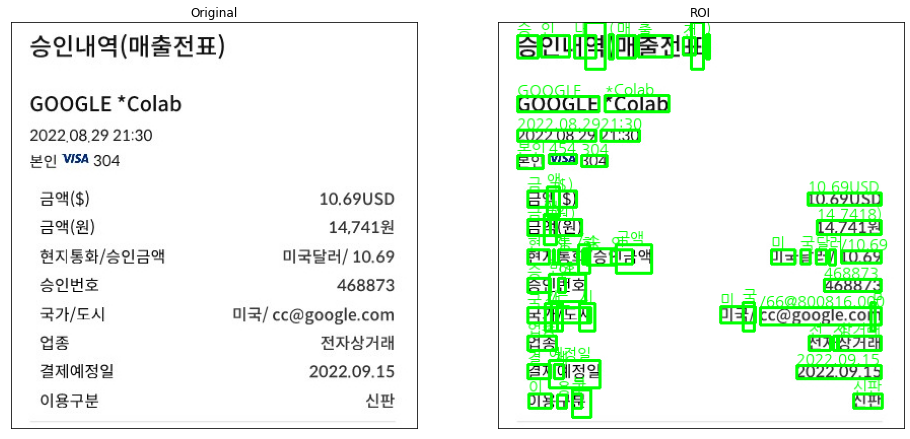

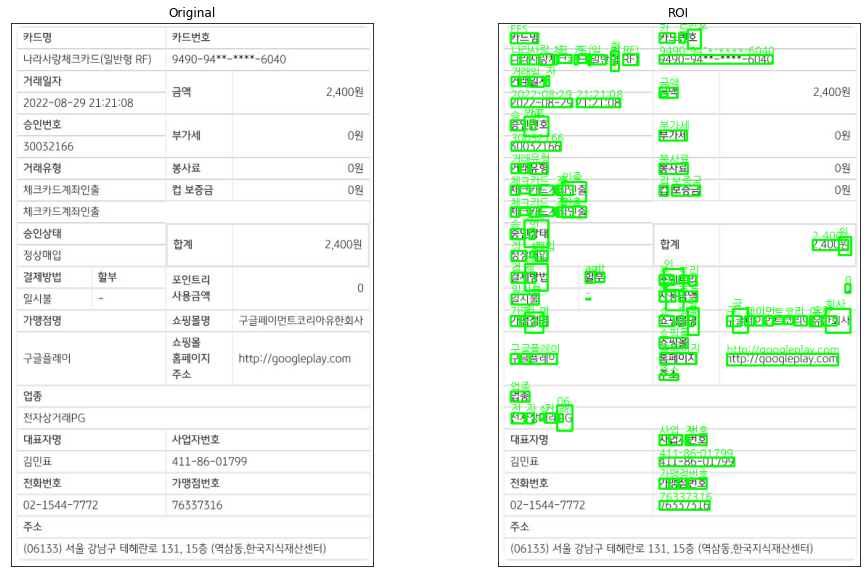

In [36]:
cropped_colab = crop_word_regions(image_paths[0], work_dir, 'colab')
cropped_drive = crop_word_regions(image_paths[1], work_dir, 'drive')

In [37]:
print(cropped_colab)

['', '', '', '', '승', '인', '내', '역', '(', '매', '출', '전', '표', ')', '', '', '', 'GOOGLE', '*Colab', '', '2022.08.29', '21:30', '', '본인', '454', '304', '', '금', '액', '($)', '', '금', '액', '(원)', '', '현', '지', '통', '화', '/', '승', '인', '금액', '', '승', '인', '번호', '', '국', '가', '/', '도', '시', '', '업종', '', '결', '제', '예정일', '', '이', '용', '구', '분', '', '', '', '10,69USD', '', '', '14,7418)', '', '', '미', '국', '달', '러', '/10.69', '', '468873', '', '', '미', '국', '/66@800816.000', 'ㅁ', '', '전', '자', '상거래', '', '2022.09.15', '', '', '신판']


In [38]:
print(cropped_drive)

['', '', '', '', 'FES', '', '', '나', '라', '사', '랑', '체', '크', '카', '드', '(', '일', '반', '형', 'RF)', '', '거', '래', '일', '자', '', '', '2022-08-29', '21:21:08', '', '', '승', '인', '번호', '', '', '30032166', '', '', '거', '래', '유형', '', '', '체', '크', '카', '드', '계', '좌', '인줄', '', '', '체', '크', '카', '드', '계', '좌', '인출', '', '', '승', '인', '상태', '', '정', '상', '매입', '', '결', '제', '방법', '', '일시불', '-', '', '', '', '가', '맹', '점', '명', '', '', '', 'ag', '', 'dt', '', '', '', '구', '글', '플레이', '', '', '', '업종', '', '전', '자', '상', '거', '래', '06', '', '', '', '카', '드', '번호', '', '', '', '9490-94"*-****-6040', '', '', '', '금액', '', '', '', '미', '', '', '', '부가세', '', '', '', '봉사료', '', '', '', '컵', '보증금', '', '', '', '포', '인', '트', '리', '', '사', '용', '금액', '', '쇼', '핑', '몰', '명', '', '쇼핑몰', '', '', '홈페이지', '', '', '', '주소', '', '', '', '사', '업', '자', '번호', '', '', '', '2.400', '원', '', '', '', '0', '', '', '', '구', '글', '페', '이', '먼', '트', '코', '리', '아', '유', '한', '회사', '', '', '', 'http://googleplay.com'

글자 단위로 추출할 때가 있고 단어 단위로 추출할 때가 있다. 기준이 뭔지 잘 모르겠다.

# 3. 테스트 결과 정리하기

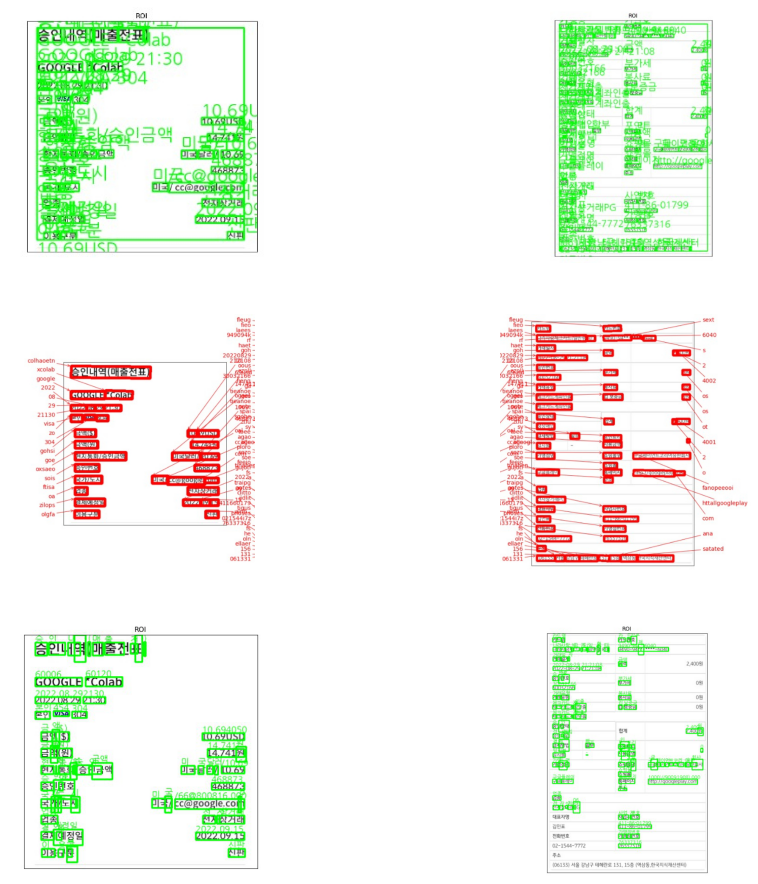

In [33]:
plt.figure(figsize=(16, 16))

for i in range(6):
    plt.subplot(3, 2, i + 1)
    image_path = img.imread(work_dir + f'/images/result_{i}.jpg')
    plt.imshow(image_path)
    plt.axis('off')

plt.show()

In [40]:
print(colab_text)
print()
print(drive_text)

승인내역(매출전표)
GOOGLE *Colab
2022,08,29 21:30
본인 VISA 304
금액($)
금액(원)
현지통화/승인금액
승인번호
국가/도시
업종
결제예정일
이용구분
10.69USD
14,741원
미국달러 / 10.69
468873
미국/cc@google.com
전자상거래
2022.09.15
신판

카드명
나라사랑체크카드(일반형 RF)
거래일자
2022-08-29 21:21:08
승인번호
30032166
거래유형
체크카드계좌인출
체크카드계좌인출
승인상태
정상매입
결제방법
일시불
가맹점명
구글플레이
할부
1
업종
전자상거래PG
대표자명
김민표
전화번호
02-1544-7772
카드번호
9490-94**-****-6040
금액
부가세
봉사료
컵 보증금
합계
포인트리
사용금액
쇼핑몰명
쇼핑몰
홈페이지
주소
2,400원
사업자번호
411-86-01799
가맹점번호
76337316
0원
0원
0원
2,400원
구글페이먼트코리아유한회사
http://googleplay.com
주소
(06133) 서울 강남구 테헤란로 131, 15층 (역삼동,한국지식재산센터)
0


In [42]:
print(cropped_colab)
print()
print(cropped_drive)

['', '', '', '', '승', '인', '내', '역', '(', '매', '출', '전', '표', ')', '', '', '', 'GOOGLE', '*Colab', '', '2022.08.29', '21:30', '', '본인', '454', '304', '', '금', '액', '($)', '', '금', '액', '(원)', '', '현', '지', '통', '화', '/', '승', '인', '금액', '', '승', '인', '번호', '', '국', '가', '/', '도', '시', '', '업종', '', '결', '제', '예정일', '', '이', '용', '구', '분', '', '', '', '10,69USD', '', '', '14,7418)', '', '', '미', '국', '달', '러', '/10.69', '', '468873', '', '', '미', '국', '/66@800816.000', 'ㅁ', '', '전', '자', '상거래', '', '2022.09.15', '', '', '신판']

['', '', '', '', 'FES', '', '', '나', '라', '사', '랑', '체', '크', '카', '드', '(', '일', '반', '형', 'RF)', '', '거', '래', '일', '자', '', '', '2022-08-29', '21:21:08', '', '', '승', '인', '번호', '', '', '30032166', '', '', '거', '래', '유형', '', '', '체', '크', '카', '드', '계', '좌', '인줄', '', '', '체', '크', '카', '드', '계', '좌', '인출', '', '', '승', '인', '상태', '', '정', '상', '매입', '', '결', '제', '방법', '', '일시불', '-', '', '', '', '가', '맹', '점', '명', '', '', '', 'ag', '', 'dt', '', '', '', '구'

# 4. 결과 분석과 결론 제시하기

영수증 OCR에서 중요한 점은 전체 문자를 인식해야 된다는 점이다.  
또한 단어 단위로 인식을 해줘야 바로 바로 해당 단어와 매칭되는 label에  
저절로 정보가 저장되는 프로그램에 적용이 잘 될 것이다.  
또한 한글이 지원이 되는 모델이어야 할 것이다.

우선 keras-ocr은 한글 지원을 안해서 탈락이다.  

Tesseract는 인식 기준을 글자와 단어 두 가지를 왔다 갔다해서 일관성이 떨어진다.  
또한 인식하지 못하는 글자들도 보인다.

이와 반대로 Google OCR API는 모든 글자들을 인식하고, 일관적으로 단어 단위로 인식하고,  
바로 실무에 도입해도 될 정도로 완벽했다.

# 5. 회고하기

## 5.1. 이번 프로젝트에서 어려웠던 점

한글로 OCR을 하려고 해서 막히는 점이 조금 있었다.  
다행히 좋은 Reference를 구해서 해결할 수 있었다.

## 5.2. 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점

keras-ocr이 한글을 지원을 안해서 성능을 알 수 없었던 것이 아쉬웠다.  

tesseract의 oem, psm 설정 부분을 제대로 이해하지 못했다.
잘 만 쓰면 Google OCR API급일 것 같다.

## 5.3. 루브릭 평가 지표를 맞추기 위해 시도한 것들

최대한 세 가지 모델을 전부 사용해 보려고 했고,  
문자들을 전부 인식하는지, 단어 단위로 인식하는지, 한글이 지원되는지  
등을 확인해서 가장 좋은 모델을 골라내었다.

## 5.4. 만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정

뭔가 쉬운 것 같으면서도 어려운 프로젝트였다.  
또한 지금까지의 프로젝트는 단순히 "무엇을 시도해보고 결과가 잘 도출되었나"  
같은 루브릭 평가 지표를 제시했다면  
이번 프로젝트는 직접 적용 가능한 서비스를 제시하고 검정까지 해야되서  
글쓰기도 잘해야 되는 것 같았다.

## 5.5. 자기 다짐

Time flashed by. The vacation is gone.

# 6. Reference

https://yunwoong.tistory.com/148